# OpenAI Universe part 2 DQN
Last part we 

In [1]:
%matplotlib notebook
from time import gmtime, strftime
import threading
import time

import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display
import tensorflow as tf
import gym
from gym import wrappers
import random

from matplotlib import animation
from JSAnimation.IPython_display import display_animation

env = gym.make('CartPole-v0')
observation = env.reset()


[2017-07-01 23:09:37,763] Making new env: CartPole-v0


In [2]:
networkstate = tf.placeholder(tf.float32, [None, 4], name="input")
networkaction = tf.placeholder(tf.int32, [None], name="actioninput")
networkreward = tf.placeholder(tf.float32,[None], name="groundtruth_reward")
action_onehot = tf.one_hot(networkaction, 2, name="actiononehot")
w1 = tf.Variable(tf.random_normal([4,16], stddev=0.35))
w2 = tf.Variable(tf.random_normal([16,32], stddev=0.35))
w3 = tf.Variable(tf.random_normal([32,8], stddev=0.35))
w4 = tf.Variable(tf.random_normal([8,2], stddev=0.35))
b1 = tf.Variable(tf.zeros([16]))
b2 = tf.Variable(tf.zeros([32]))
b3 = tf.Variable(tf.zeros([8]))
b4 = tf.Variable(tf.zeros(2))
layer = networkstate
layer = tf.nn.relu(tf.add(tf.matmul(layer,w1), b1))
layer = tf.nn.relu(tf.add(tf.matmul(layer,w2), b2))
layer = tf.nn.relu(tf.add(tf.matmul(layer,w3), b3))
predictedreward = tf.add(tf.matmul(layer,w4), b4)
qreward = tf.reduce_sum(tf.multiply(predictedreward, action_onehot), reduction_indices = 1)
loss = tf.reduce_mean(tf.square(networkreward - qreward))
tf.summary.scalar('loss', loss)
optimizer = tf.train.RMSPropOptimizer(0.0001).minimize(loss)
merged_summary = tf.summary.merge_all()


In [3]:

sess = tf.InteractiveSession()
summary_writer = tf.summary.FileWriter('trainsummary',sess.graph)
sess.run(tf.global_variables_initializer())




In [4]:
replay_memory = [] # (state, action, reward, terminalstate, state_t+1)
epsilon = 1.0
BATCH_SIZE = 32
GAMMA = 0.9
MAX_LEN_REPLAY_MEMORY = 30000

for i_epoch in range(300001):
    action = env.action_space.sample() 
    newobservation, reward, terminal, info = env.step(action)

    if terminal: 
        reward = 0
        
    replay_memory.append((observation, action, reward, terminal, newobservation))
    
    if terminal: 
        newobservation = env.reset()
    observation = newobservation
    
    
    
    # LEARN! 
    if len(replay_memory) > 1000: 
        experiences = random.sample(replay_memory, BATCH_SIZE)
        totrain = [] # (state, action, delayed_reward)
        nextstates = [var[4] for var in experiences]
        pred_reward = sess.run(predictedreward, feed_dict={networkstate:nextstates})
        for index in range(BATCH_SIZE):
            state, action, reward, terminalstate, newstate = experiences[index]
            predicted_reward = max(pred_reward[index])
            
            if terminalstate:
                delayedreward = reward
            else:
                delayedreward = reward + GAMMA*predicted_reward
            totrain.append((state, action, delayedreward))
        states = [var[0] for var in totrain]
        actions = [var[1] for var in totrain]
        rewards = [var[2] for var in totrain]
        _, l, summary = sess.run([optimizer, loss, merged_summary], feed_dict={networkstate:states, networkaction: actions, networkreward: rewards})
        if len(replay_memory) > MAX_LEN_REPLAY_MEMORY:
            replay_memory = replay_memory[-MAX_LEN_REPLAY_MEMORY:]
            
        if i_epoch%100==1:
            summary_writer.add_summary(summary, i_epoch)
        if i_epoch%1000==1:
            print("Epoch %d, loss: %f" % (i_epoch,l))

Epoch 1001, loss: 1.061129
Epoch 2001, loss: 1.499748
Epoch 3001, loss: 3.847623
Epoch 4001, loss: 4.456052
Epoch 5001, loss: 12.699602
Epoch 6001, loss: 0.602108
Epoch 7001, loss: 4.740539
Epoch 8001, loss: 2.541575
Epoch 9001, loss: 2.030831
Epoch 10001, loss: 3.434848
Epoch 11001, loss: 0.180284
Epoch 12001, loss: 2.240081
Epoch 13001, loss: 2.315157
Epoch 14001, loss: 0.138402
Epoch 15001, loss: 2.762174
Epoch 16001, loss: 0.593311
Epoch 17001, loss: 2.070810
Epoch 18001, loss: 0.157125
Epoch 19001, loss: 0.157634
Epoch 20001, loss: 8.168095


KeyboardInterrupt: 

In [ ]:
pred_reward


In [ ]:

# frames = []
# def display_frames_as_gif(frames):
#     """
#     Displays a list of frames as a gif, with controls
#     """
#     plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
#     patch = plt.imshow(frames[0])
#     plt.axis('off')

#     def animate(i):
#         patch.set_data(frames[i])

#     anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
#     anim.save('animation.gif', writer = 'imagemagick', fps=20)
#     display(display_animation(anim, default_mode='loop'))


# observation = env.reset()
# terminal = False
# lasts = 0
# pred_rewards = []
# while not (terminal or lasts > 500):
#     lasts += 1
#     action = env.action_space.sample() 
#     pred_reward = sess.run(predictedreward, feed_dict={networkstate:[observation]})
#     print(pred_reward)
#     pred_rewards.append(max(max(pred_reward)))
#     action = np.argmax(pred_reward)
    
# #    print(pred_reward)
#     observation, reward, terminal, info = env.step(action)
#     frame = env.render(mode = 'rgb_array')
#     frames.append(frame)

# print(len(frames))
# #display_frames_as_gif(frames)

In [ ]:
# plt.plot(pred_rewards)

In [ ]:
# pred_rewards

In [ ]:
# display_frames_as_gif(frames)

In [ ]:
# import time
# %matplotlib notebook
# observation = env.reset()
# terminal = False
# lasts = 0
# pred_rewards = []
# frames = []
# TRESHOLD = 9.5
# while not (terminal or lasts > 500):
#     lasts += 1
#     pred_reward = sess.run(predictedreward, feed_dict={networkstate:[observation]})
#     now = env.render(mode = 'rgb_array')
#     plt.imshow(now)
#     plt.show()
#     if max(max(pred_reward)) < TRESHOLD:
#         print("Need input!")

#     time.sleep(1)

        
#     pred_rewards.append(max(max(pred_reward)))
#     action = np.argmax(pred_reward)
    
# #    print(pred_reward)
#     observation, reward, terminal, info = env.step(action)
#     frame = env.render(mode = 'rgb_array')
#     frames.append(frame)
# print(len(frames))

In [ ]:
# import threading
# %matplotlib notebook
# observation = env.reset()
# TRESHOLD = 12.0
# user_gave_input = False
# def performaction(action):
#     global observation
#     global terminal
#     observation, reward, terminal, info = env.step(action)
#     print "action done"

# def updatestep():
#     global terminal
#     global user_gave_input
#     global useraction
#     print("in updatestep")
#     now = env.render(mode = 'rgb_array')
#     plt.clf()
#     plt.imshow(now)
#     plt.show()
    
#     pred_reward = sess.run(predictedreward, feed_dict={networkstate:[observation]})
    
#     if max(max(pred_reward)) > TRESHOLD:
#         print("expected ok")
#         action = np.argmax(pred_reward)
#         performaction(action)
#     else:
#         if user_gave_input:
#             print("user gave input")
#             action = useraction
#             user_gave_input = False
#             performaction(action)
#         else:
#             print("Please give input")
#     if not terminal:    
#         print("going for new one")
#         threading.Timer(0.2, updatestep).start()
#     else:
#         print("Done, you are dead...")







# ######



# def leftclicked(something):
#     global user_gave_input
#     global useraction
#     user_gave_input = True
#     useraction = 0
    
# def rightclicked(something):
#     global user_gave_input
#     global useraction
#     user_gave_input = True
#     useraction = 1
    
# def display_buttons():
#     """ Display the buttons you can use to apply a force to the cart """
#     left = widgets.Button(description="<")
#     right = widgets.Button(description=">")
#     display(left, right)
    
#     left.on_click(leftclicked)
#     right.on_click(rightclicked)

# #fig,ax = plt.subplots()
# #im = ax.imshow(firstframe) 

# # Show the buttons to control the cart
# display_buttons()

# updatestep()


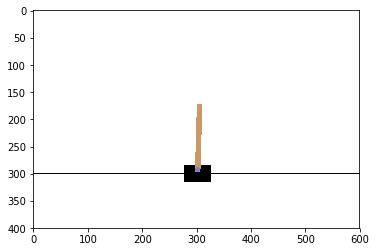

Max expected: 10.9888


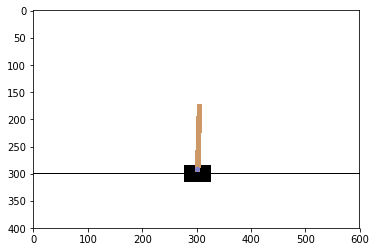

Max expected: 10.8928


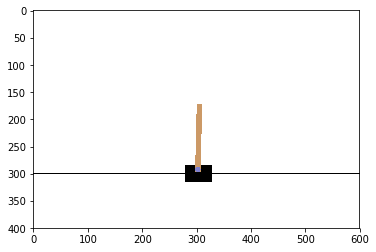

Max expected: 10.9704


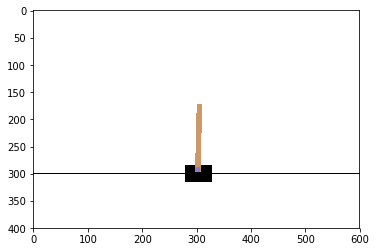

Max expected: 10.8804


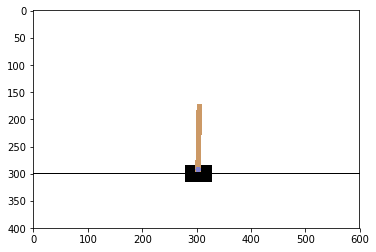

Max expected: 10.9551


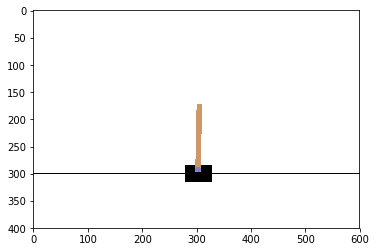

Max expected: 10.8697


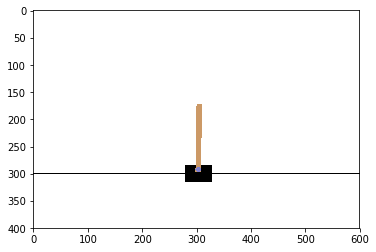

Max expected: 10.9424


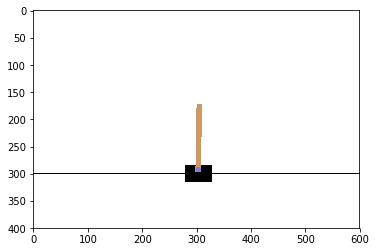

Max expected: 10.8604


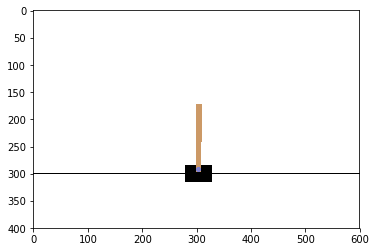

Max expected: 10.932


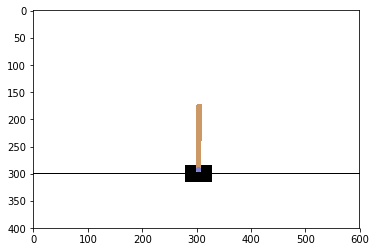

Max expected: 10.8523


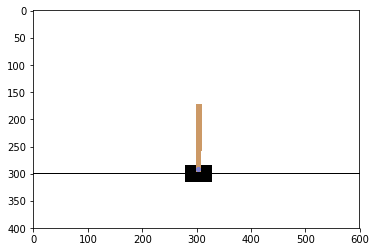

Max expected: 10.9235


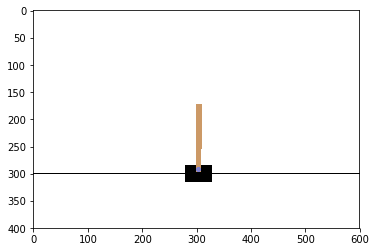

Max expected: 10.8451


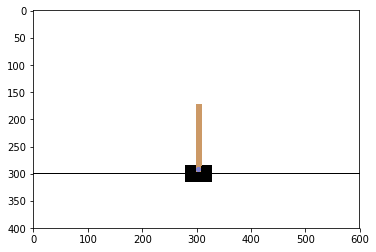

Max expected: 10.9166


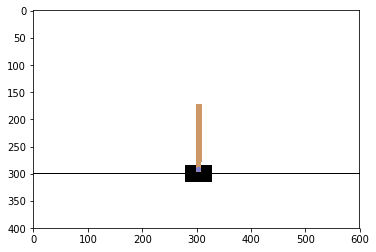

Max expected: 10.8386


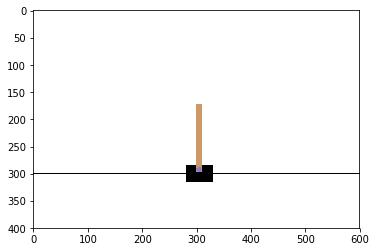

Max expected: 10.911


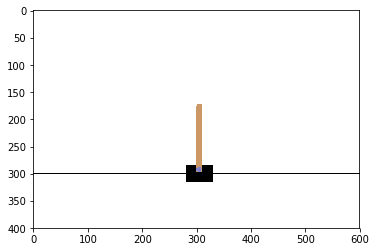

Max expected: 10.8327


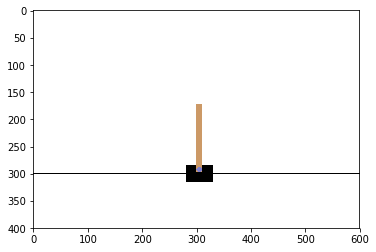

Max expected: 10.9065


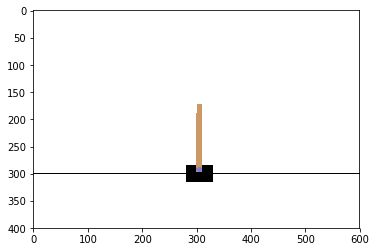

Max expected: 10.8271


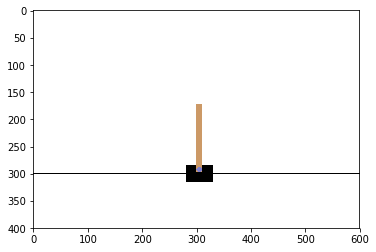

Max expected: 10.9029


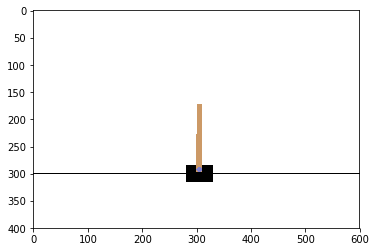

Max expected: 10.8218


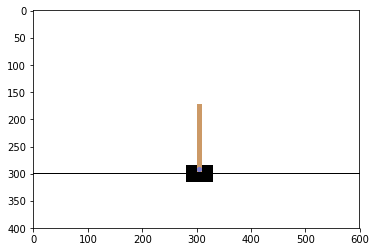

Max expected: 10.9


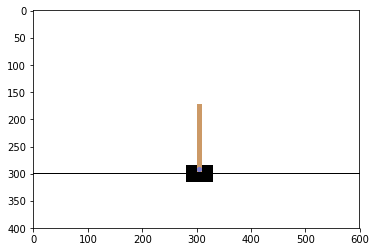

Max expected: 10.8166


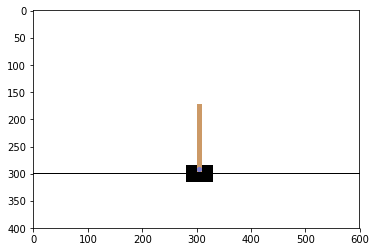

Max expected: 10.8976


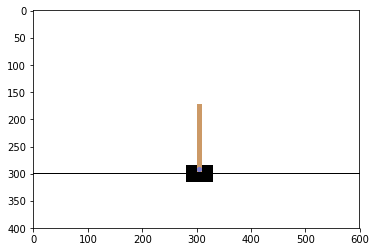

Max expected: 10.8114


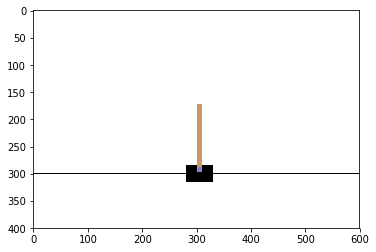

Max expected: 10.8957


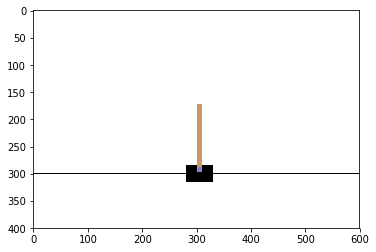

Max expected: 10.8059


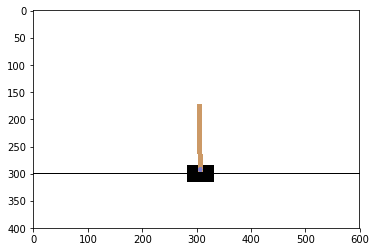

Max expected: 10.8941


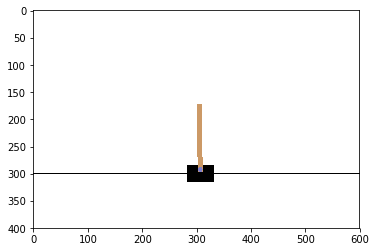

Max expected: 10.8002


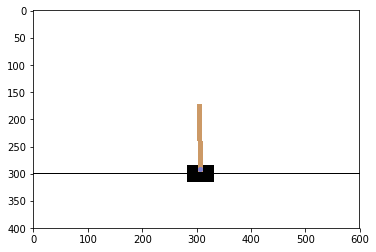

Max expected: 10.8926


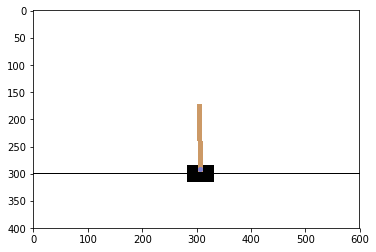

Max expected: 10.794


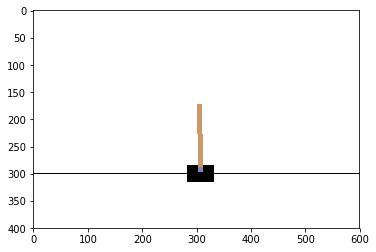

Max expected: 10.8912


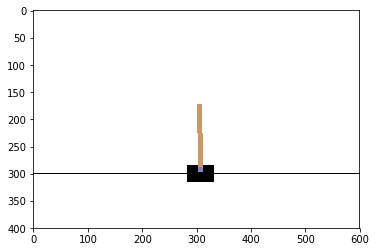

Max expected: 10.7872 left (0) or right(1): 0
Thank you, performing: 0


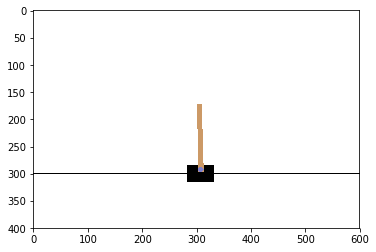

Max expected: 10.8898


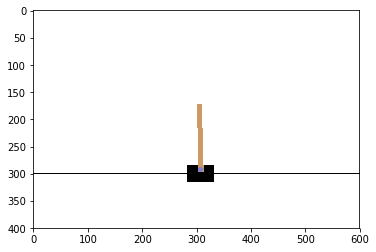

Max expected: 10.7796 left (0) or right(1): 0
Thank you, performing: 0


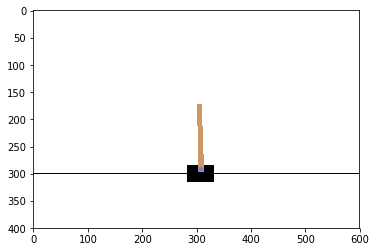

Max expected: 10.8882


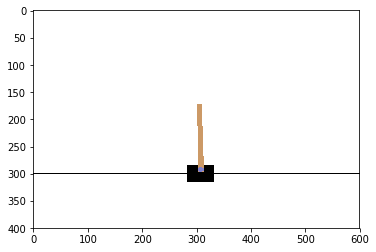

Max expected: 10.7711 left (0) or right(1): 0
Thank you, performing: 0


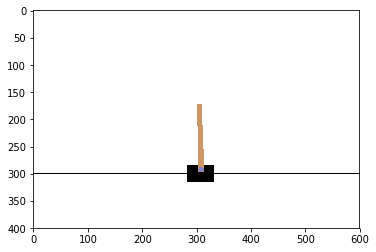

Max expected: 10.8864


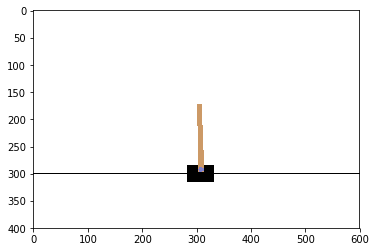

Max expected: 10.7613 left (0) or right(1): 0
Thank you, performing: 0


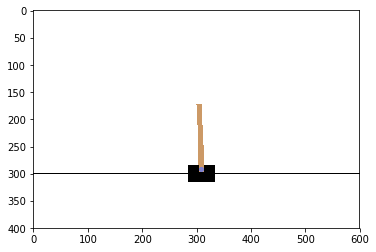

Max expected: 10.8842


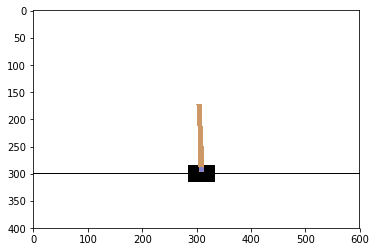

Max expected: 10.7502 left (0) or right(1): 0
Thank you, performing: 0


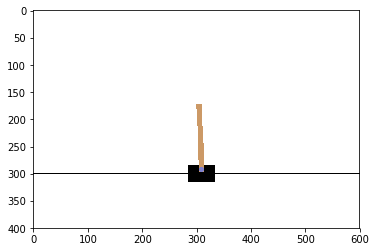

Max expected: 10.8815


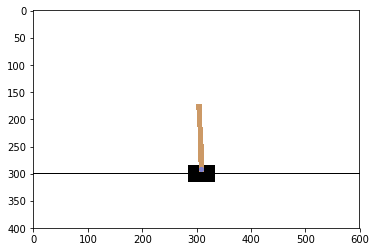

Max expected: 10.7374 left (0) or right(1): 0
Thank you, performing: 0


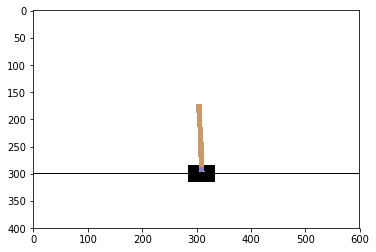

Max expected: 10.8949


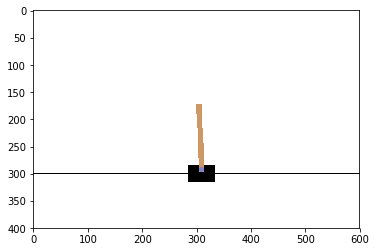

Max expected: 11.1312


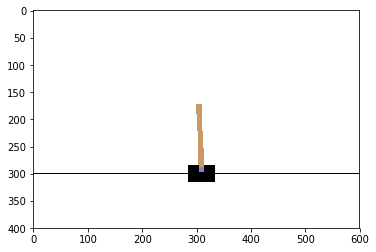

Max expected: 10.9353


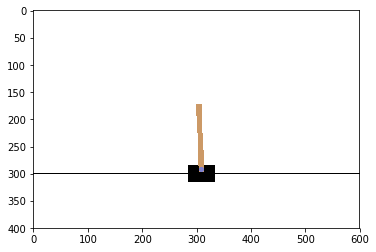

Max expected: 11.1596


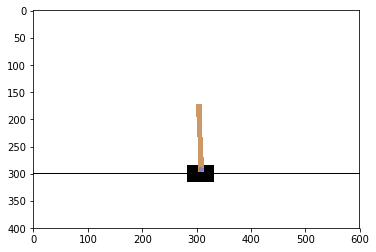

Max expected: 10.9682


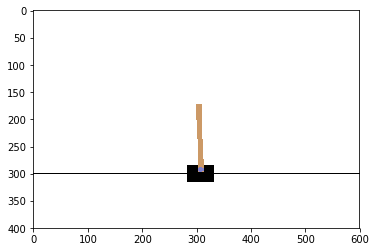

Max expected: 11.1741


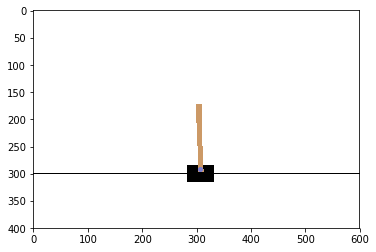

Max expected: 10.9825


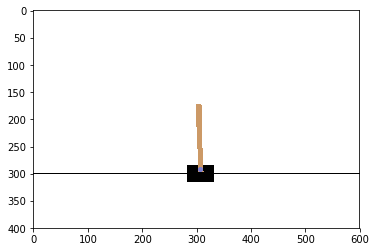

Max expected: 11.1831


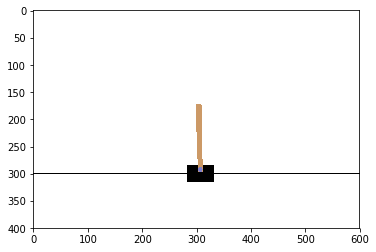

Max expected: 10.9943


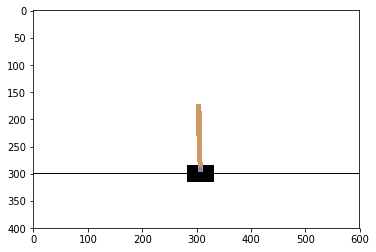

Max expected: 11.1898


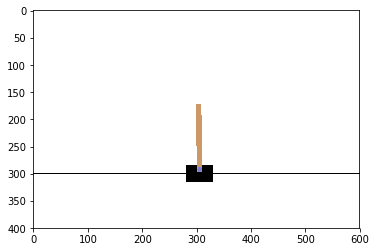

Max expected: 11.0039


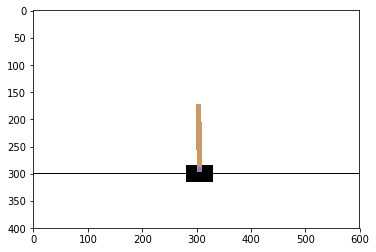

Max expected: 11.1945


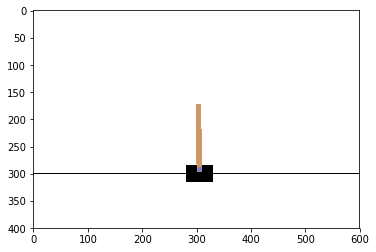

Max expected: 11.0116


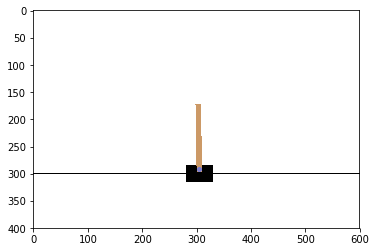

Max expected: 11.1975


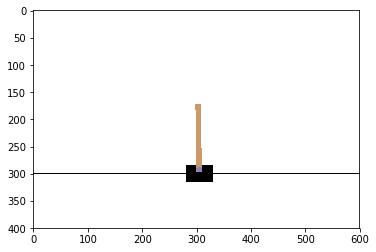

Max expected: 11.0178


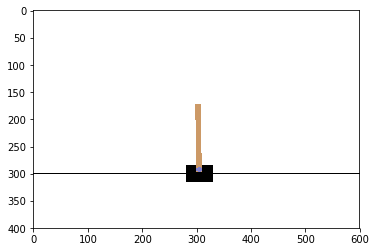

Max expected: 11.199


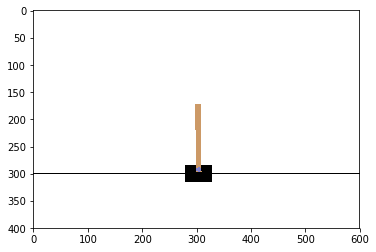

Max expected: 11.0226


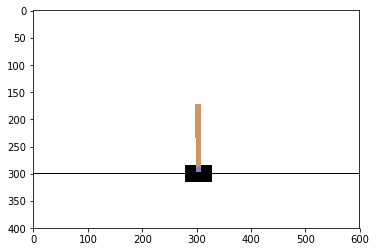

Max expected: 11.1993


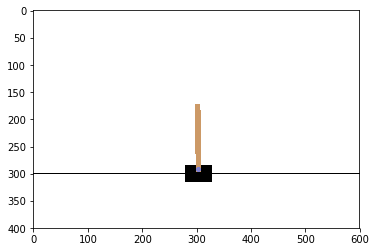

Max expected: 11.0262


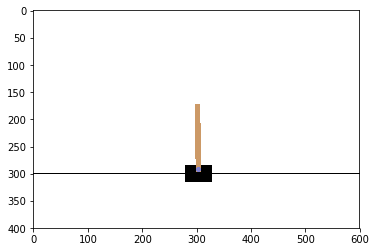

Max expected: 11.1984


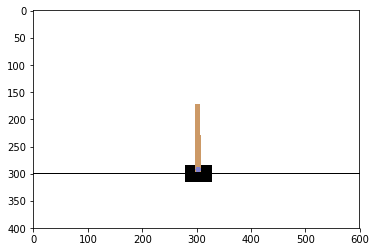

Max expected: 11.0288


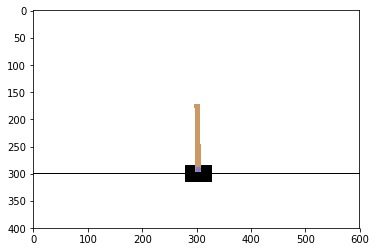

Max expected: 11.1966


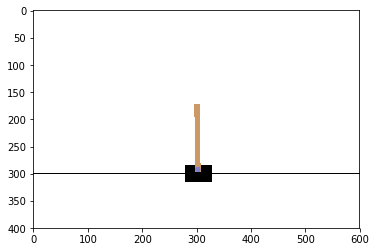

Max expected: 11.0305


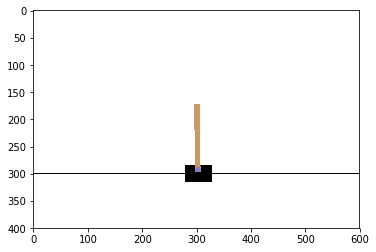

Max expected: 11.1939


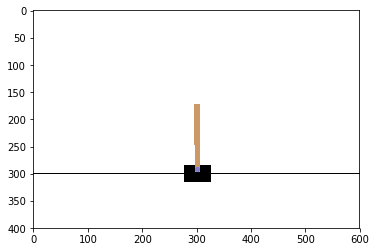

Max expected: 11.0315


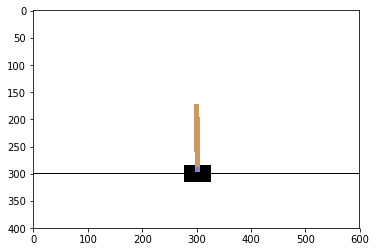

Max expected: 11.1904


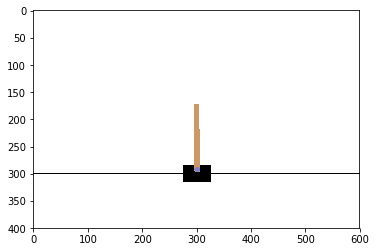

Max expected: 11.0317


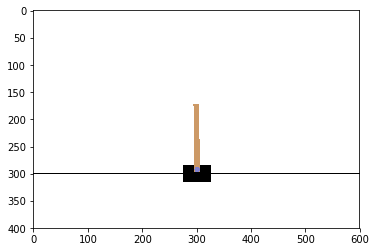

Max expected: 11.1861


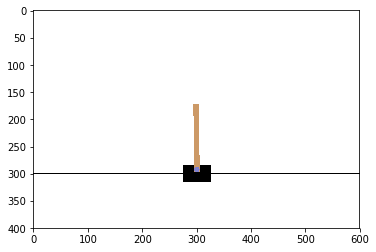

Max expected: 11.0313


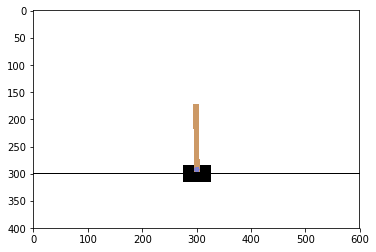

Max expected: 11.1812


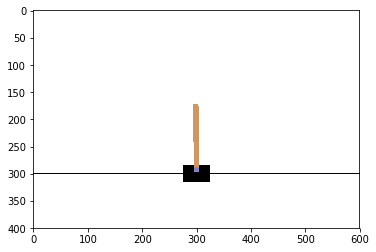

Max expected: 11.0303


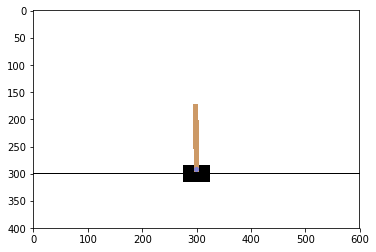

Max expected: 11.1756


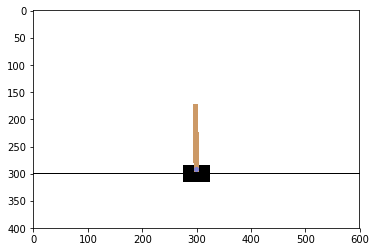

Max expected: 11.0287


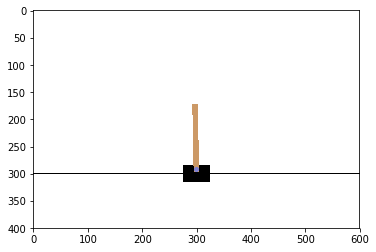

Max expected: 11.1693


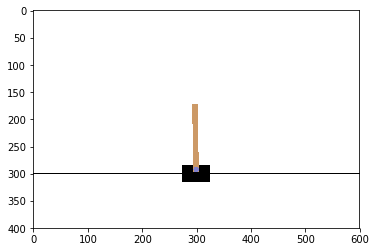

Max expected: 11.0267


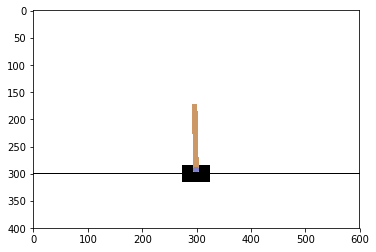

Max expected: 11.1623


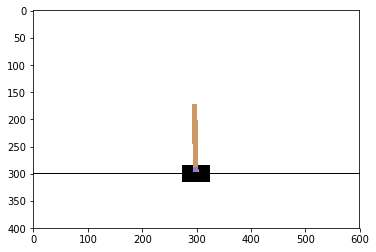

Max expected: 11.024


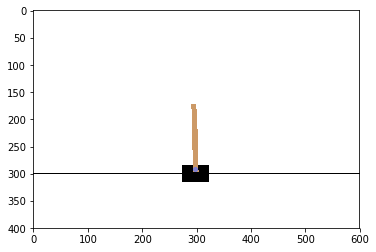

Max expected: 11.1547


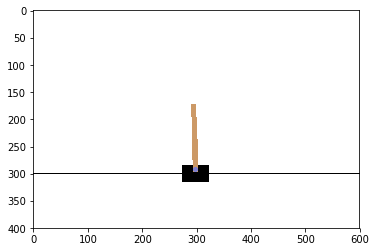

Max expected: 11.0209


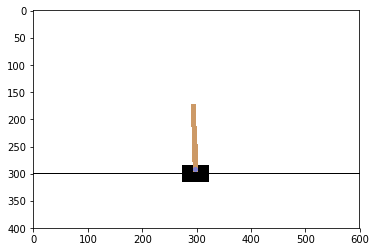

Max expected: 11.1462


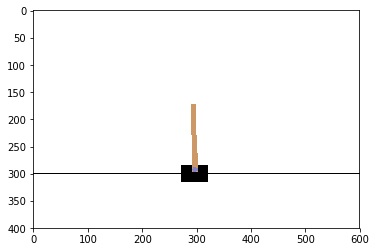

Max expected: 11.0171


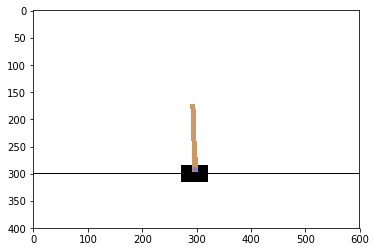

Max expected: 11.137


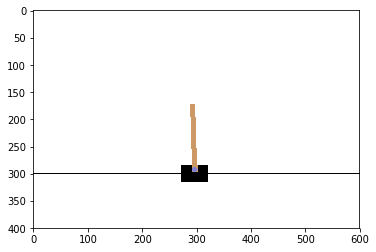

Max expected: 11.0128


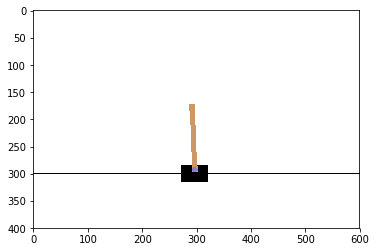

Max expected: 11.1268


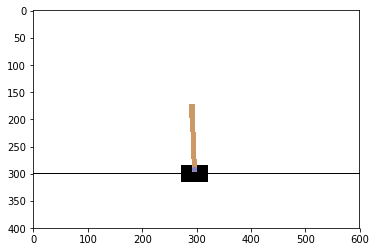

Max expected: 11.0078


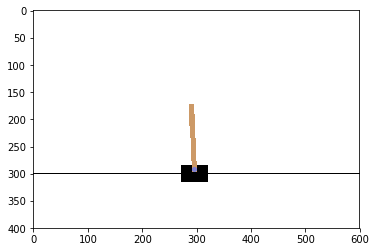

Max expected: 11.1156


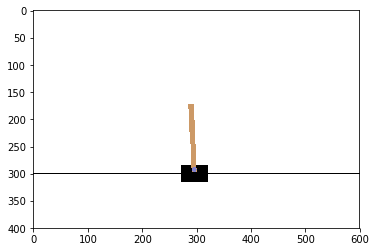

Max expected: 10.9911


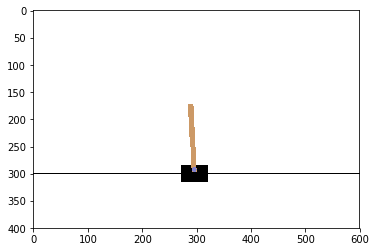

Max expected: 11.1167


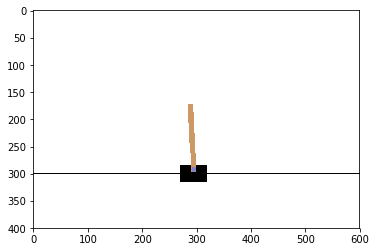

Max expected: 11.3146


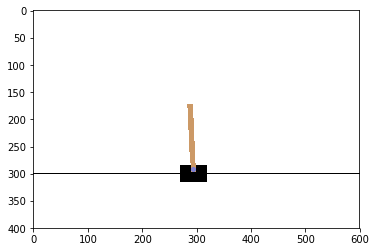

Max expected: 11.1428


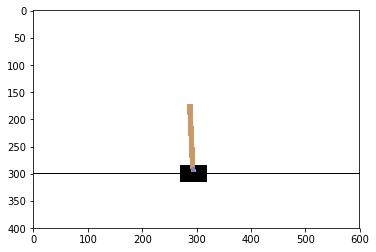

Max expected: 11.3378


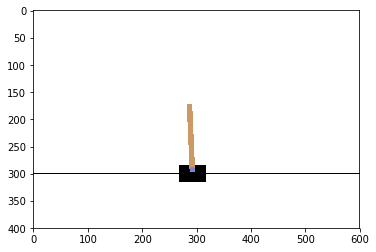

Max expected: 11.1563


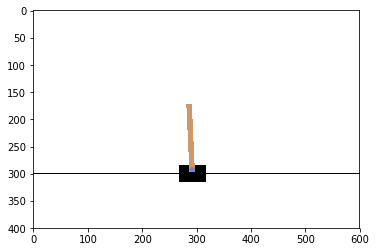

Max expected: 11.3566


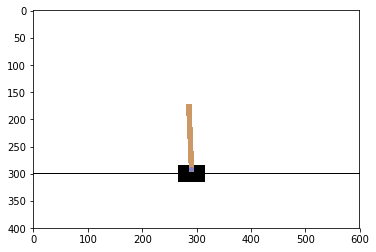

Max expected: 11.1664


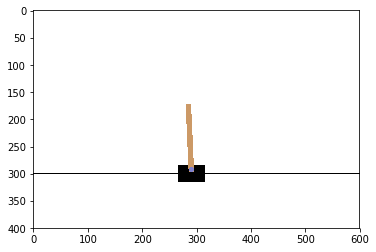

Max expected: 11.3721


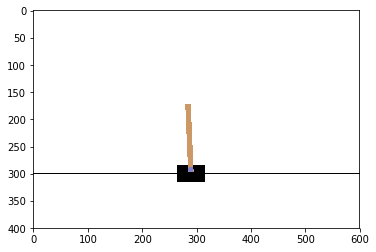

Max expected: 11.1735


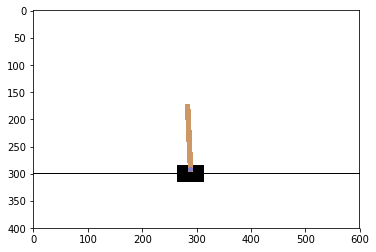

Max expected: 11.3672


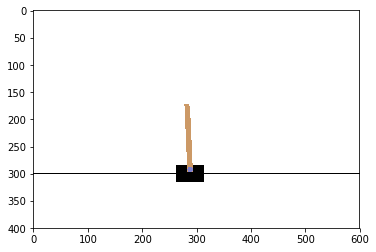

Max expected: 11.1779


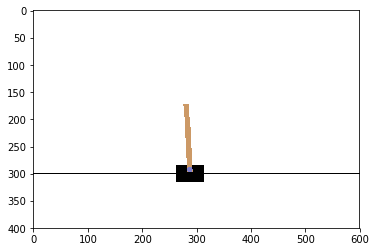

Max expected: 11.3594


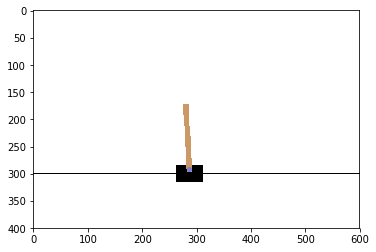

Max expected: 11.1799


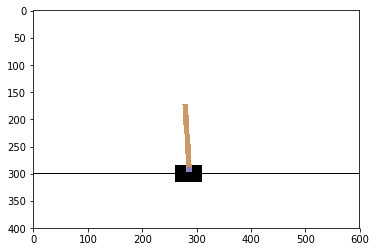

Max expected: 11.3491


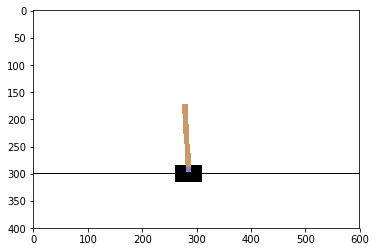

Max expected: 11.1798


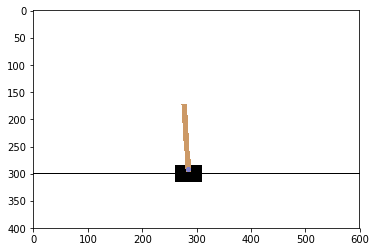

Max expected: 11.3364


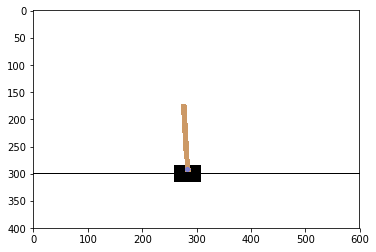

Max expected: 11.1776


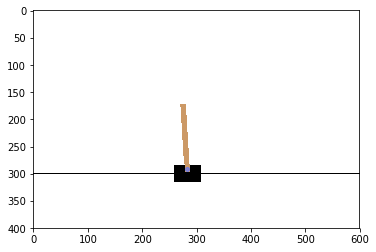

Max expected: 11.3213


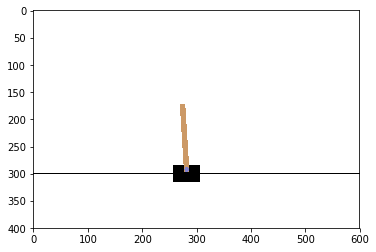

Max expected: 11.1734


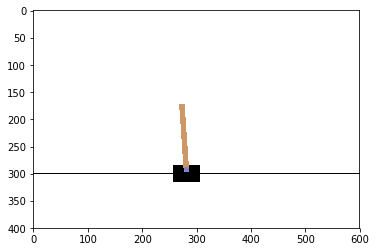

Max expected: 11.3038


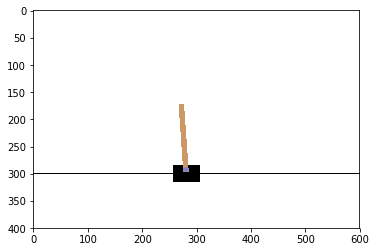

Max expected: 11.1674


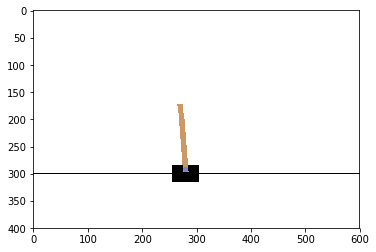

Max expected: 11.2903


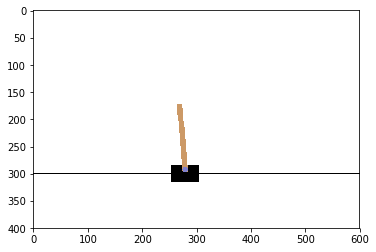

Max expected: 11.4824


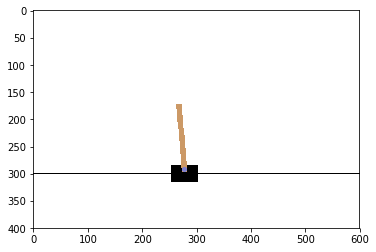

Max expected: 11.3058


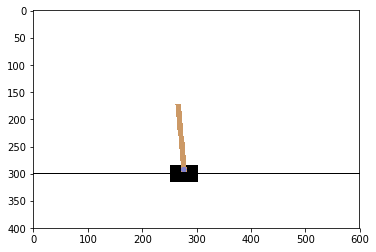

Max expected: 11.5118


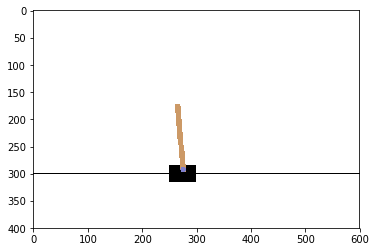

Max expected: 11.3163


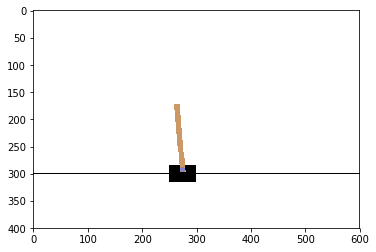

Max expected: 11.5304


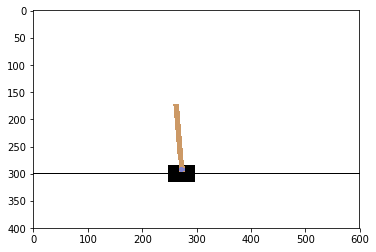

Max expected: 11.3224


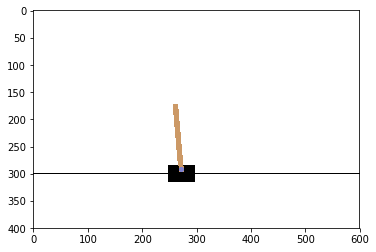

Max expected: 11.5162


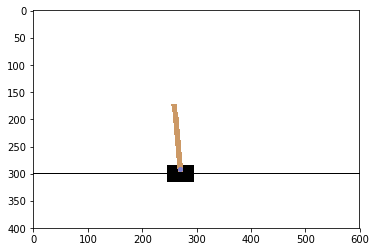

Max expected: 11.3244


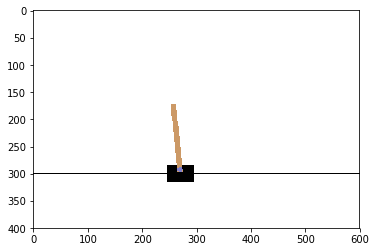

Max expected: 11.4977


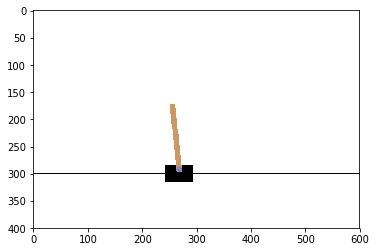

Max expected: 11.3228


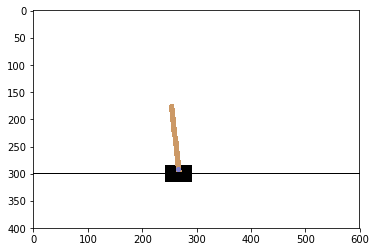

Max expected: 11.4476


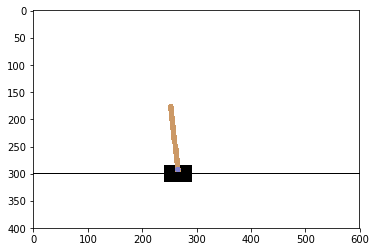

Max expected: 11.6311


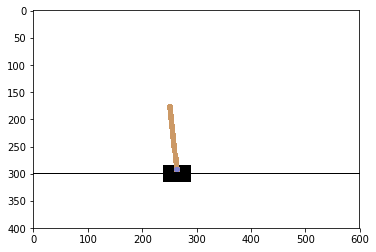

Max expected: 11.4651


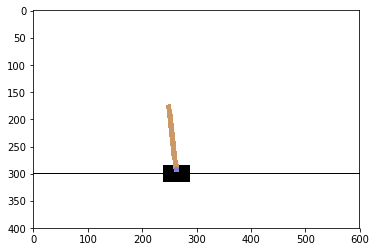

Max expected: 11.6672


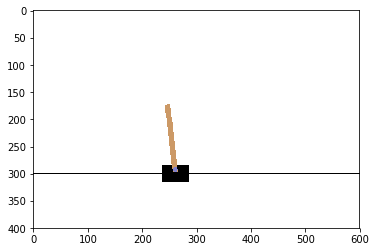

Max expected: 11.4762


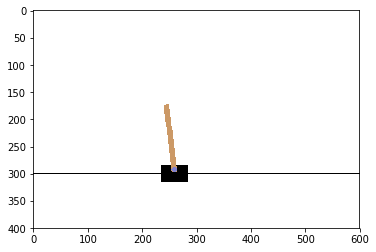

Max expected: 11.7008


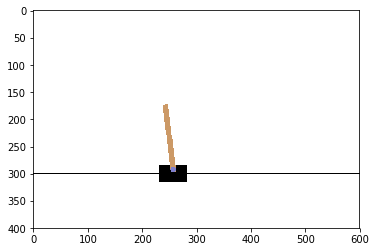

Max expected: 11.4816


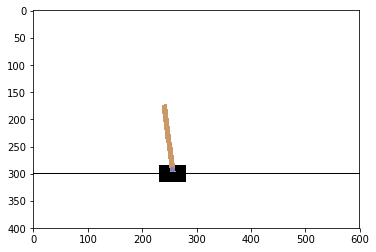

Max expected: 11.6708


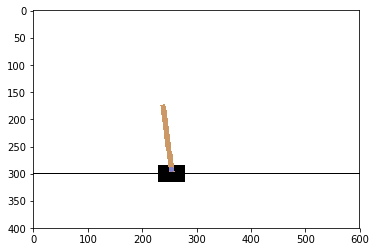

Max expected: 11.4818


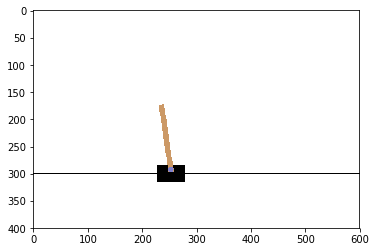

Max expected: 11.6076


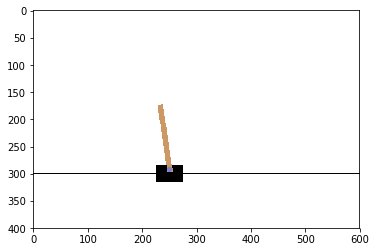

Max expected: 11.7715


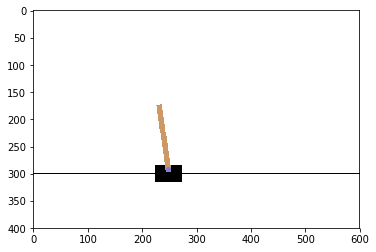

Max expected: 11.6249


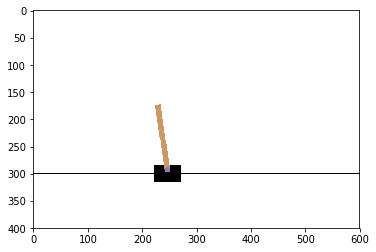

Max expected: 11.8189


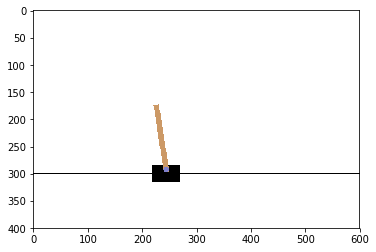

Max expected: 11.6346


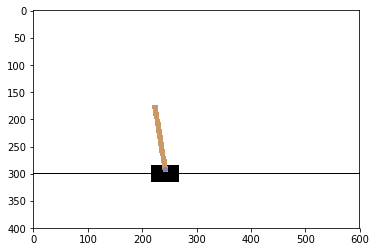

Max expected: 11.8348


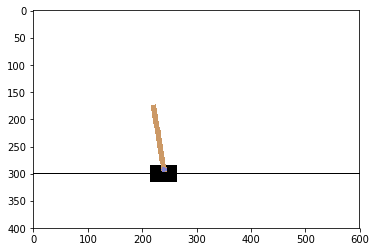

Max expected: 11.6375


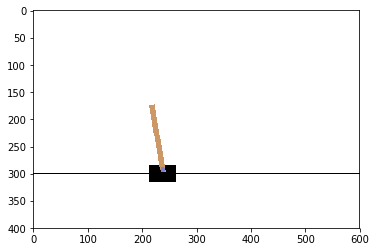

Max expected: 11.7647


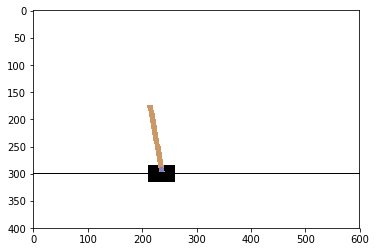

Max expected: 12.0262


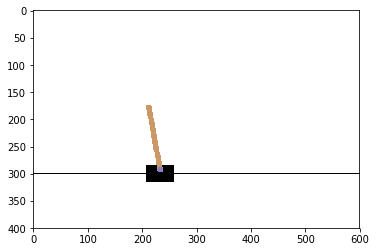

Max expected: 11.7965


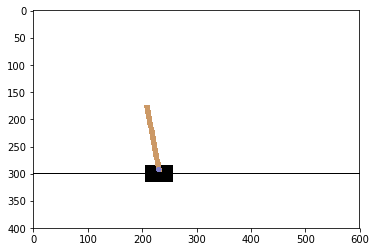

Max expected: 12.1042


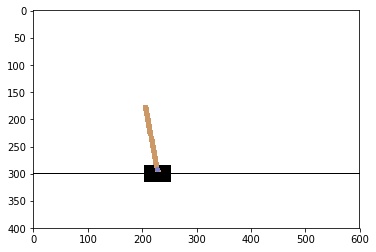

Max expected: 11.898


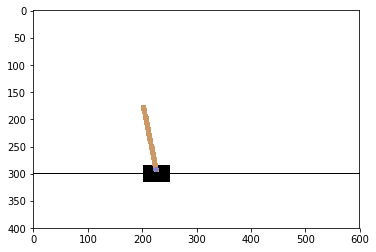

Max expected: 12.0738


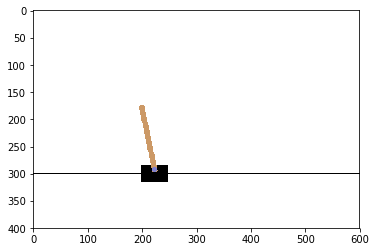

Max expected: 12.3112


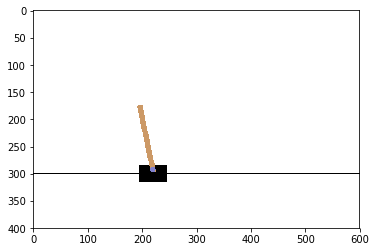

Max expected: 12.2357
Hes dead


In [5]:

observation = env.reset()
TRESHOLD = max(max(sess.run(predictedreward, feed_dict={networkstate:[observation]})))-0.2


%matplotlib inline
######


term = False
plt.ion()
while not term:
    now = env.render(mode = 'rgb_array')
    plt.clf()
    plt.imshow(now)
    plt.show()

    pred_reward = sess.run(predictedreward, feed_dict={networkstate:[observation]})
    maxexpected = max(max(pred_reward))
    if maxexpected > TRESHOLD: 
        action = np.argmax(pred_reward)
        print("Max expected: " + str(maxexpected))
        time.sleep(0.5)
    else:
        action = -1
        while action < 0:
            try:
                action = int(raw_input("Max expected: " + str(maxexpected) + " left (0) or right(1): "))
                print("Thank you, performing: " + str(action))
            except:
                pass
    observation, _, term, _ = env.step(action)

print("Hes dead")

# 